<div style="font-weight: bold; color:#5D8AA8" align="center">
    <div style="font-size: xx-large">Optimization</div><br>
    <div style="font-size: x-large; color:gray">Practical assignment</div><br>
    <div style="font-size: large">José Antonio Álvarez Ocete</div>
    <div style="font-size: large">Francisco Javier Saez Maldonado</div><br></div><hr>
</div>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

## Task 1.1: Dicotomic search method

The following cell implements the dicotomic search (also known as binary search) for a given function `f`.

In [2]:
def dicotomic_search(f, interval, l=0.005, epsilon=1e-10, verbose=False):
    """
        Implements binary search looking for the min value in
        `f` inside the interval `interval`.
        
        Pre-requisites:
        - f must be estrictly cuasiconvex inside the
            given interval.
        
        Arguments:
        - f -> callable
            Function to be minimized.
        - initial_interval -> numpy.darray
            Interval where to look for the minimum
        - l -> float
            Precision of the search. The returned interval
            will have length smaller than l.
        - epsilon -> float
            The distance taken from the middle element the 
            subinterval cut performed in each step of the
            algorithm.
        
        Returns the index of the first instance of the element.
        If the element is not in the array, returns -1.
    """
    # Initialize indexes
    i_lower, i_upper = interval
    k = 1
    
    # Apply binary search to find the element
    while i_upper - i_lower >= l:
        # Compute middle pivotss
        middle_cut = (i_upper + i_lower) / 2.0
        mc_left = middle_cut - epsilon
        mc_right = middle_cut + epsilon
        
        # Update subarray in study
        if f(mc_left) < f(mc_right):
            i_upper = mc_right
        else:
            i_lower = mc_left
        
        # Update the steps counter
        k += 1
            
    if verbose:
        print("Steps taken: {}".format(k))
        
    return (i_lower, i_upper)

In order to try this algorithm we have developed an automated testing system implemented in the next cells. The algorithm is then tested with three different functions:

\begin{align*}
    f_1(x) & = sin(x) & \quad x \in [-3, 1] \\
    f_2(x) & = x^2 & \quad x \in [-4, 4] \\
    f_3(x) & = \sqrt{|x|} & \quad x \in [-3, 3] \\
\end{align*}

Steps taken: 11


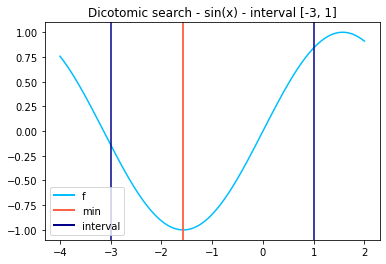

Steps taken: 12


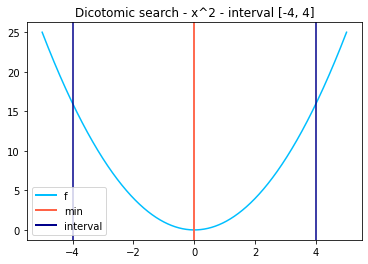

Steps taken: 12


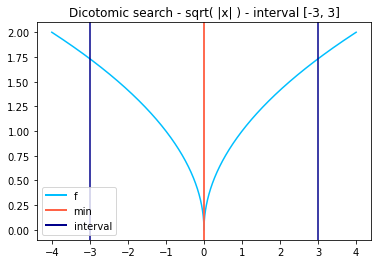

In [3]:
def test_search_algorithm(algorithm, f, interval, title=None):
    i_init, i_end = interval[0]-1, interval[1]+1 
    step = 0.0001
    
    x = np.arange(i_init, i_end, step)
    plt.plot(x, f(x), color='deepskyblue')
    
    min_int = algorithm(f, interval, verbose=True)
    plt.axvline(x=min_int[0], color='tomato')
    plt.axvline(x=min_int[1], color='tomato')

    plt.axvline(x=interval[0], color='darkblue')
    plt.axvline(x=interval[1], color='darkblue')
    
    if title is not None:
        plt.title(title)
    
    custom_lines = [Line2D([0], [0], color='deepskyblue', lw=2),
                    Line2D([0], [0], color='tomato', lw=2),
                    Line2D([0], [0], color='darkblue', lw=2)]
    plt.legend(custom_lines, ['f', 'min', 'interval'])

def run_all_tests(algorithm, algorithm_name=''):
    test_cases = [
        (np.sin, [-3, 1], 'sin(x)'),
        (lambda x: x**2, [-4, 4], 'x^2'),
        (lambda x: np.sqrt(np.abs(x)), [-3, 3], 'sqrt( |x| )')
    ]

    for f, interval, f_name in test_cases:
        title = '{} - {} - interval {}'.format(algorithm_name, f_name, interval)
        test_search_algorithm(algorithm, f, interval, title)
        plt.show()

run_all_tests(dicotomic_search, 'Dicotomic search')

We can see how the algorithm an average of $11.6$ steps in the different functions to find the minimum. The last example offers a none-diferentiable convex function, where the algorithm also works.

## Task 1.2: Golden section method

In the following cell we implement the golden section method, quite similar to the previous algorithm.

In [4]:
def golden_section(f, interval, l=0.005, epsilon=1e-10, verbose=False):
    """
        Implements binary search looking for the min value in
        `f` inside the interval `interval`.
        
        Pre-requisites:
        - f must be estrictly cuasiconvex inside the
            given interval.
        
        Arguments:
        - f -> callable
            Function to be minimized.
        - initial_interval -> numpy.darray
            Interval where to look for the minimum
        - l -> float
            Precision of the search. The returned interval
            will have length smaller than l.
        - epsilon -> float
            The distance taken from the middle element the 
            subinterval cut performed in each step of the
            algorithm.
        
        Returns the index of the first instance of the element.
        If the element is not in the array, returns -1.
    """
    # Initialize indexes
    i_lower, i_upper = interval
    alpha = 0.618
    k = 1
    
    # Compute first middle pivots
    pivot_left = i_lower + (1 - alpha)*(i_upper - i_lower)
    pivot_right = i_lower + alpha*(i_upper - i_lower)
    
    # Eval pivots
    f_left = f(pivot_left)
    f_right = f(pivot_right)
    
    # Apply binary search to find the element
    while i_upper - i_lower >= l:
        # Update subarray in study
        if f_left > f_right:
            i_lower = pivot_left
            pivot_left = pivot_right
            f_left = f_right
            
            pivot_right = i_lower + alpha*(i_upper - i_lower)
            f_right = f(pivot_right) 
        else:
            i_upper = pivot_right
            pivot_right = pivot_left
            f_right = f_left
            
            pivot_left = i_lower + (1 - alpha)*(i_upper - i_lower)
            f_left = f(pivot_left) 
        
        # Update the steps counter
        k += 1
            
    if verbose:
        print("Steps taken: {}".format(k))
        
    return (i_lower, i_upper)

We now run the previous tests with this new algorithm:

Steps taken: 15


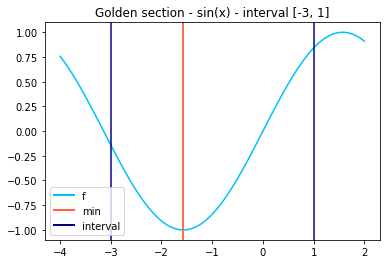

Steps taken: 17


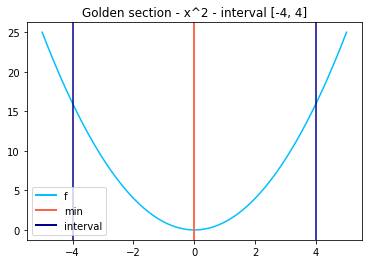

Steps taken: 16


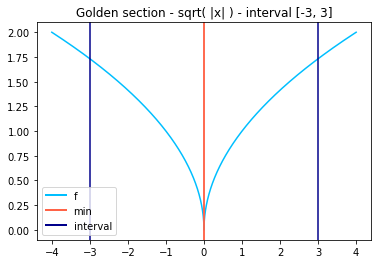

In [5]:
run_all_tests(golden_section, 'Golden section')

We can see how this algorithm also finds the maximum but the dicotomic search method does it in a fewer number of steps.

## Task 2.1: Hooke-Jeeves method

Changing to multidimensional optimization, we first implement a function that, given a callable function and the succesion of points obtained, plots a contour of the function and the succesion. It will be used for testing the implementation.

In [6]:
def plot_contour(f, Xs, title='', xlims=[-0.5, 3.5], ylims=[-0.5, 4]):
    x0, x1 = xlims
    y0, y1 = ylims
    x = np.arange(x0, x1, 0.01)
    y = np.arange(y0, y1, 0.01)
    xx, yy = np.meshgrid(x, y)
    z = f([xx, yy])

    # Contour plot
    plt.figure(figsize=(12,8))
    cont = plt.contour(x, y, z, levels=30)
    plt.title(r"Contour plot of $f(x)$")
    plt.xlabel('x')
    plt.ylabel('y')
    plt.clabel(cont, inline=True, fontsize=10)
    plt.scatter(Xs[0,0], Xs[0,1], color="green", marker="o", label="Start", zorder=20)
    plt.scatter(Xs[:, 0], Xs[:, 1], s=20, color='black', zorder=10, label='$\{x_n\}$')
    plt.scatter(2, 1, color="red", marker="*", label="Minimum")
    plt.plot(Xs[:, 0], Xs[:, 1], "-.", lw=2)
    plt.legend()
    if title != '':
        plt.title(title)
    plt.show()

The following cell implements the Hooke-Jeeves method. It fixes a direction `d` and minimizes the function:

$$
    g(\lambda) = f(x_n + \lambda \cdot d)
$$

where $x_n, d \in \mathbb R^n$ and $\lambda \in \mathbb R$. That is, $g$ takes a single-dimensional value and can be optimized using the methods from the previous tasks. We will use dicotomic search to this end, although it has been parametrized so others one-directional optimizers may be used in the future.

In [7]:
def hooke_jeeves(f, start_point,
                 epsilon=1e-5,
                 max_steps=10**6, 
                 one_directional_optimizer=dicotomic_search,
                 interval_radius=5,
                 verbose=False):
    """
        Implements the Hooke-Jeeves method.
        
        Pre-requisites:
        - f must be convex and have a minimum.
        
        Arguments:
        - f -> callable
            2D function to be minimized.
        - start_point -> numpy.darray
            Initial point.
        - epsilon -> float
            Minimum distance between jumps. If the jump
            distance is smaller (|x_ - x_n+1| < eps),
            end the algorithm.
        - one_directional_optimizer -> callable
            Algorithm used to find the minimum in a
            single direction.
        - interval_radius -> float
            Radius of the interval used for one
            directional optimization.
        - max_steps -> int
            Fixes the max number of iterations.
        
        Returns the list of points that the algorithm went through.
        The min of f will be its last position.
    """
    # Initialize variables
    x_n = start_point
    previous_x_n = x_n
    Xs = np.array([x_n])
    k = 1
    d_i = 0
    dimensions = len(x_n)
    interval = (-interval_radius, interval_radius)
    
    while k <= max_steps:
        # Prepare optimization direction
        if d_i != -1:
            direction = np.zeros(dimensions)
            direction[d_i] = 1
        else:
            direction = x_n - previous_x_n
            
        # Prepare optimization function using the direction
        directional_f = lambda x: f(x_n + x*direction)
        
        # Use 1-direction optimization in the computed direction
        found_interval = one_directional_optimizer(directional_f, interval,
                                                   epsilon=epsilon)
        jump_length = (found_interval[0] + found_interval[1]) / 2.0
        x_n = x_n + jump_length*direction
        Xs = np.vstack([Xs, x_n])
        
        # Update the steps counter and the direction index
        k += 1
        d_i = d_i + 1 if d_i + 1 < dimensions else -1
        
        # Update diagonal pivot point if we have gone through
        # all the dimensions
        if d_i == 0:
            previous_x_n = x_n
        
        # Check stop condition
        if np.linalg.norm(x_n - Xs[-2]) < epsilon:
            break
            
    if verbose:
        print("Steps taken: {}".format(k))
        
    return Xs

For testing, we used the function provided in the lecture slides:
    
$$
    f(x, y) = (x-2)^4 + (x - 2y)^2
$$

Steps taken: 1001


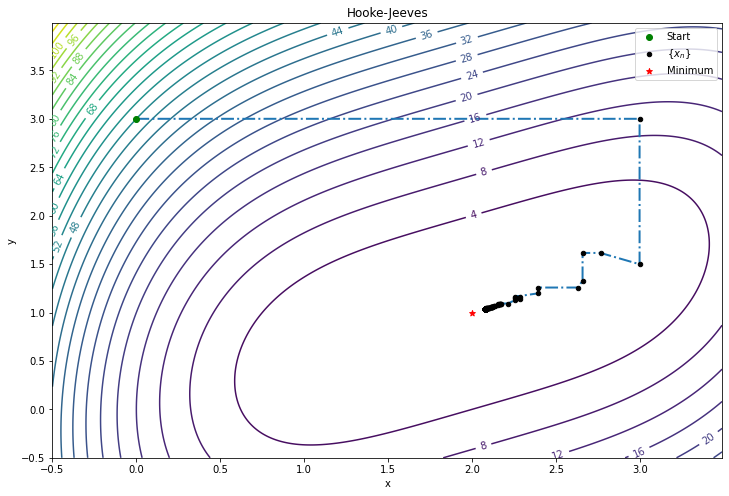

In [8]:
f = lambda x: (x[0] - 2)**4 + (x[0] - 2*x[1])**2

Xs = hooke_jeeves(f, start_point=[0,3],
                  interval_radius=3,
                  max_steps=1000,
                  epsilon=1e-6,
                  verbose=True)

plot_contour(f, Xs, 'Hooke-Jeeves')

We can see how we approach the minimum following the Hoove-Jeeves pattern: the first two steps are performed in the direction of an axis, while the third one is diagonal. As expected, the pattern repeats every three steps.

We may also distinguish how the convergence really slows on the end. This happens because the slected function is quite flat near the minimum point, as we can appreciate using [geogebra](https://www.geogebra.org/3d/yxpphzad).

## Task 2.2: Gradient descent

Next up, we implement gradient descent. In each step we will use the same trick as before, optimizing a single-dimensional function where the new direction is the gradient in that point:

$$
    g(\lambda) = f\left(x_n - \lambda \cdot \frac{\nabla f(x_n)}{\parallel \nabla f(x_n) \parallel}\right)
$$


In [9]:
def gradient_descent(f,
                     d_f,
                     start_point,
                     epsilon=1e-5,
                     max_steps=10**6, 
                     one_directional_optimizer=dicotomic_search,
                     interval_radius=5,
                     verbose=False):
    """
        Implements the Hooke-Jeeves method.
        
        Pre-requisites:
        - f must be convex and have a minimum.
        
        Arguments:
        - f -> callable
            2D function to be minimized.
        - d_f -> callable
            Gradient of f.
        - start_point -> numpy.darray
            Initial point.
        - epsilon -> float
            Minimum distance between jumps. If the jump
            distance is smaller (|x_ - x_n+1| < eps),
            end the algorithm.
        - one_directional_optimizer -> callable
            Algorithm used to find the minimum in a
            single direction.
        - interval_radius -> float
            Radius of the interval used for one
            directional optimization.
        - max_steps -> int
            Fixes the max number of iterations.
        
        Returns the list of points that the algorithm went through.
        The min of f will be its last position.
    """
    # Initialize variables
    x_n = start_point
    Xs = np.array([x_n])
    k = 1
    interval = (-interval_radius, interval_radius)
    
    while k <= max_steps:
        # Prepare optimization direction by using the gradient
        direction = - d_f(x_n)
        
        # Check if we are already at the minimum
        if np.linalg.norm(direction) < epsilon:
            break
        
        # Normalize gradient direction
        direction = direction / np.linalg.norm(direction)
            
        # Prepare optimization function using the direction
        directional_f = lambda x: f(x_n + x*direction)
        
        # Use 1-direction optimization in the computed direction
        found_interval = one_directional_optimizer(directional_f, interval)
        jump_length = (found_interval[0] + found_interval[1]) / 2.0
        x_n = x_n + jump_length*direction
        Xs = np.vstack([Xs, x_n])
        
        # Update the steps counter and the direction index
        k += 1
            
    if verbose:
        print("Steps taken: {}".format(k))
        
    return Xs

We repeat the test with the new method. Additionally, we need to provide our gradient method with the gradient of our function:

$$
    \nabla f(x, y) = \left( 4(x-2)^3 + 2x - 4y, -4x + 8y \right)
$$

Steps taken: 1001


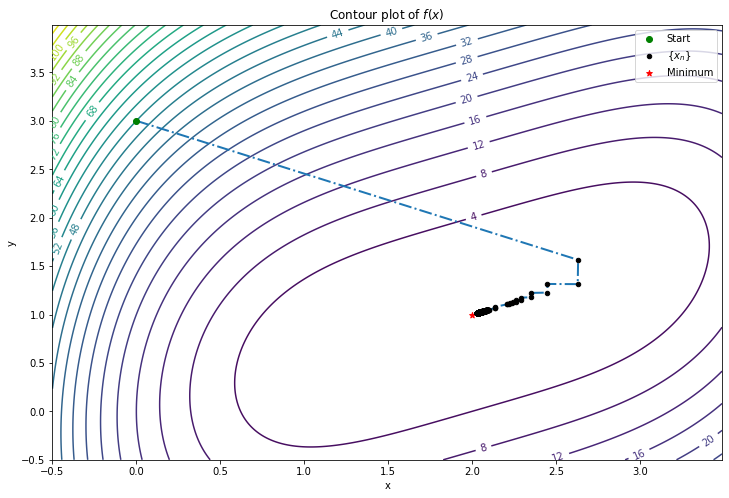

In [10]:
d_f = lambda x: np.array([4*(x[0] - 2)**3 + 2*x[0] - 4*x[1],
                          -4*x[0] + 8*x[1]], dtype=float)

Xs = gradient_descent(f, d_f,
                      start_point=[0,3],
                      interval_radius=3,
                      epsilon=0.005,
                      max_steps=10**3,
                      verbose=True)

plot_contour(f, Xs)

We can see how the gradient takes us astonishingly close to the flat area of the surface in a single step. During the following ones, it appears that the gradient takes single axis direction, although this is just a visual effect: we have displayed the gradients (i.e. the directions) at each steped and it showed that they weren't single dimensional.

This behaviour its again associated to the flattnes of the surface: the gradient becomes quite small, which affects on how difficult finding the best optimization direction is. This is why the algorithm takes the maximum number of iterations ($1000$) and doesn't quite reach the optimal value, although it ends closer than the previous method.

## Task 3: Multidimensional Newton method

Finally, we implement the multidimensional Newton method. It uses the Hessian matrix of the `f` to find a better direction and step. The next-step expression can expressed as

$$
    x_{n+1} = x_n - \left( \text{Hess }f (x_n) \right)^{-1} \nabla f(x_n).
$$

The method itself is implemented in the following cell.

In [11]:
def multidimensional_newton(f,
                     d_f,
                     Hess_f,
                     start_point,
                     epsilon=1e-5,
                     max_steps=10**6, 
                     verbose=False):
    """
        Implements the Hooke-Jeeves method.
        
        Pre-requisites:
        - f must be convex and have a minimum.
        
        Arguments:
        - f -> callable
            2D function to be minimized.
        - d_f -> callable
            Gradient of f.
        - Hess_f -> callable
            Hessian matrix of f.
        - start_point -> numpy.darray
            Initial point.
        - epsilon -> float
            Minimum distance between jumps. If the jump
            distance is smaller (|x_ - x_n+1| < eps),
            end the algorithm.
        - max_steps -> int
            Fixes the max number of iterations.
        
        Returns the list of points that the algorithm went through.
        The min of f will be its last position.
    """
    # Initialize variables
    x_n = start_point
    Xs = np.array([x_n])
    k = 1
    
    while k <= max_steps:
        # Prepare optimization direction by using the gradient
        eval_gradient = d_f(x_n)
        eval_hess = Hess_f(x_n)
        inv_eval_hess = np.linalg.inv(eval_hess)
        
        # Compute next step
        x_n = x_n - eval_gradient @ inv_eval_hess.T
        Xs = np.vstack([Xs, x_n])
        
        # Update the steps counter
        k += 1
        
        # Check stop condition
        if np.linalg.norm(x_n - Xs[-2]) < epsilon:
            break

    if verbose:
        print("Steps taken: {}".format(k))
        
    return Xs

Finally, we try this last method with our previous test case. Apart from the function and its gradient, we need to provide the methid with a evaluable Hessian function:

$$
    \text{Hess }f(x,y) =
    \begin{pmatrix}
        12(x-2)^2 + 2 & -4 \\
        -4 & 8
    \end{pmatrix}
$$

Steps taken: 15


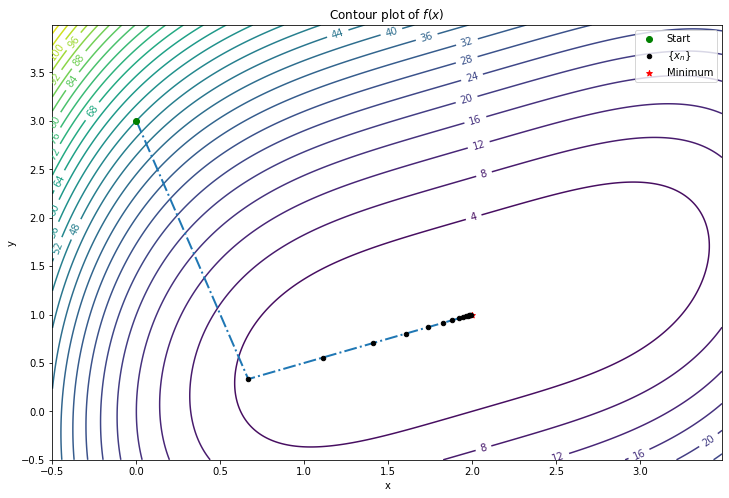

In [12]:
Hess_f = lambda x: np.array(
    [
        [12*(x[0] - 2)**2 + 2, -4],
        [-4, 8]
    ], dtype=float)

Xs = multidimensional_newton(
    f, d_f, Hess_f,
    start_point=[0,3],
    epsilon=0.005,
    max_steps=10**3,
    verbose=True
)

plot_contour(f, Xs)

We can see how this method is much faster, arriving at the minimum value with only 15 iterations. It captures and uses the geometry of the surface better, although it has certain disadvantages: the function `f` has to be twice differentiable, and the expression of the gradient and its Hessian must be either computed or approximated.